In [16]:
import dataframe_image as dfi
import matplotlib.pyplot as plt
import mlrose_hiive
import mlrose
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, train_test_split, validation_curve)   
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from yellowbrick.model_selection import LearningCurve, ValidationCurve
np.random.seed(42)

In [17]:
def load_data(dataset):
    # df = pd.read_csv("data/" + dataset, header=None)
    df = pd.read_csv("data/" + dataset)
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    print("Dataset Filename: {}".format(dataset))
    print()

    print("Number of features: {}".format(len(df.columns) - 1))
    print()

    print("Total Samples: {}".format(len(df)))
    print()
    
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)

    return X_train, X_test, y_train, y_test

def generate_nn_curves(clf_name, clf, dataset, loss_curve, X_train, y_train, X_test, y_test):
    # Following code was taken from the users TomDLT and Chenn on Stack Overflow
    # https://stackoverflow.com/questions/46912557/is-it-possible-to-get-test-scores-for-each-iteration-of-mlpclassifier
    plt.title("Loss Curve for {}".format(dataset))
    plt.xlabel("epoch")
    plt.plot(loss_curve)
    plt.savefig("results/{}_loss_curve_{}.png".format(clf_name, dataset))
    plt.clf()

#     X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
#     X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    """ Home-made mini-batch learning
    -> not to be used in out-of-core setting!
    """
    N_TRAIN_SAMPLES = X_train.shape[0]
    N_EPOCHS = 1200
    N_BATCH = 50
    N_CLASSES = np.unique(y_train)

    scores_train = []
    scores_test = []


    # EPOCH
    epoch = 0
    while epoch < N_EPOCHS:
        # SHUFFLING
        random_perm = np.random.permutation(X_train.shape[0])
        mini_batch_index = 0
        while True:
            # MINI-BATCH
            indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
            clf.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
            mini_batch_index += N_BATCH

            if mini_batch_index >= N_TRAIN_SAMPLES:
                break

        # SCORE TRAIN
        scores_train.append(clf.score(X_train, y_train))

        # SCORE TEST
        scores_test.append(clf.score(X_test, y_test))

        epoch += 1

    """ Plot """
    plt.plot(scores_train, alpha=0.8, label="Training score", color="#0272a2")
    plt.plot(scores_test, alpha=0.8, label="Cross-validation score", color="#9fc377")
    plt.title("Accuracy over epochs", fontsize=14)
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.savefig("results/{}_accuracy_over_epochs_{}.png".format(clf_name, dataset))
    plt.clf()
    

def generate_learning_curve(model, clf_name, scoring, sizes, cv, n_jobs, dataset_name, X_train, y_train):
    viz = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, n_jobs=n_jobs)
    viz.fit(X_train, y_train)        
    viz.show("results/{}_learning_curve_{}.png".format(clf_name, dataset_name)) 
    plt.clf()
    
def record_metrics(name, score):
    filename = "results/metrics.csv"
    with open(filename, 'a+') as f:
        timestamp = time.time()
        f.write("{}|{}|{}\n".format(timestamp, name, score))

In [18]:
# Load Data
X_train, X_test, y_train, y_test = load_data("tic-tac-toe-modified.data")

# Best hyper parameters
learning_rate_init = 0.01

Dataset Filename: tic-tac-toe-modified.data

Number of features: 9

Total Samples: 958



In [19]:
"""
Back Prop Case
"""
clf = mlrose_hiive.NeuralNetwork(hidden_nodes=[5,2], activation='tanh',
                           algorithm = 'gradient_descent',early_stopping = True,
                           max_attempts = 100, max_iters = 5000,
                           bias = True, learning_rate = .01,
                           restarts=0, curve = True, random_state=42)

start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
base_time = end_time-start_time
#generate_nn_curves("nn_base", clf, "tic-tac-toe", clf.loss, X_train, y_train, X_test, y_test)
#generate_learning_curve(clf, "nn_base", "accuracy", np.linspace(0.1, 1.0, 10), None, 8, "tic-tac-toe", X_train, y_train)
y_pred = clf.predict(X_test)
base_final_score = accuracy_score(y_test, y_pred)
record_metrics("nn_base", base_final_score)
gd_fitness_curve = clf.fitness_curve

In [20]:
"""
Random Hill Climb
"""
clf = mlrose_hiive.NeuralNetwork(hidden_nodes=[5,2], activation='tanh',
                           algorithm = 'random_hill_climb', early_stopping = True,
                           max_attempts = 100, max_iters = 5000,
                           bias = True, learning_rate = .01,
                           restarts=0, curve = True, random_state=42)

start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
rhc_time = end_time-start_time
# generate_nn_curves("nn_base", clf, "tic-tac-toe", clf.loss_curve_, X_train, y_train, X_test, y_test)
# generate_learning_curve(clf, "nn_base", "accuracy", np.linspace(0.1, 1.0, 10), None, 8, "tic-tac-toe", X_train, y_train)
y_pred = clf.predict(X_test)
rhc_final_score = accuracy_score(y_test, y_pred)
record_metrics("nn_rhc", rhc_final_score)
rhc_fitness_curve = clf.fitness_curve

In [21]:
"""
Simulated Annealing
"""
clf = mlrose_hiive.NeuralNetwork(hidden_nodes=[5,2], activation='tanh',
                           algorithm = 'simulated_annealing', early_stopping = True,
                           max_attempts = 100, max_iters = 5000,
                           bias = True, learning_rate = .01,
                           restarts=0, curve = True, random_state=42)
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
sa_time = end_time-start_time
# generate_nn_curves("nn_base", clf, "tic-tac-toe", clf.loss_curve_, X_train, y_train, X_test, y_test)
# generate_learning_curve(clf, "nn_base", "accuracy", np.linspace(0.1, 1.0, 10), None, 8, "tic-tac-toe", X_train, y_train)
y_pred = clf.predict(X_test)
sa_final_score = accuracy_score(y_test, y_pred)
record_metrics("nn_sa", sa_final_score)
sa_fitness_curve = clf.fitness_curve

In [22]:
"""
Genetic Algorithm
"""
clf = mlrose_hiive.NeuralNetwork(hidden_nodes=[5,2], activation='tanh',
                           algorithm = 'genetic_alg', early_stopping = True,
                           max_attempts = 100, max_iters = 5000,
                           bias = True, learning_rate = .01,
                           restarts=0, curve = True, random_state=42)

clf.fit(X_train, y_train)
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
ga_time = end_time-start_time
# generate_nn_curves("nn_base", clf, "tic-tac-toe", clf.loss_curve_, X_train, y_train, X_test, y_test)
# generate_learning_curve(clf, "nn_base", "accuracy", np.linspace(0.1, 1.0, 10), None, 8, "tic-tac-toe", X_train, y_train)
y_pred = clf.predict(X_test)
ga_final_score = accuracy_score(y_test, y_pred)
record_metrics("nn_ga", ga_final_score)
ga_fitness_curve = clf.fitness_curve

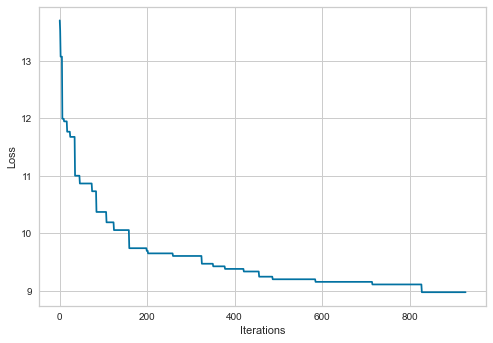

In [23]:
plt.plot(gd_fitness_curve)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("results/nn_gd_loss.png")
plt.clf()

plt.plot(rhc_fitness_curve)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("results/nn_rhc_loss.png")
plt.clf()

plt.plot(sa_fitness_curve)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("results/nn_sa_loss.png")
plt.clf()

plt.plot(ga_fitness_curve)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("results/nn_ga_loss.png")

In [27]:
base_time

9.166600942611694

In [28]:
sa_time

7.908144235610962

In [29]:
rhc_time

5.957801103591919

In [30]:
ga_time

161.74189019203186